In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
G = 6.67e-11
delta_t = 10

In [3]:
class CosmicBody:
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray, radius=0.0):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.delta_V = np.array([0., 0.])
        self.radius = radius

    def destroy(self):
        self.mass = 0.0
        
    def move(self):
        if self.is_destroyed():
            return
        self.vec_v += self.delta_V
        self.vec_P += self.vec_v * delta_t
        
    def is_destroyed(self):
        return self.mass == 0.0

    def gravitate(self, bodys: list):
        if self.is_destroyed():
            return
        
        masses = np.array([body.mass for body in bodys])
        r = np.array([np.linalg.norm(body.vec_P - self.vec_P) for body in bodys])
        
        is_destroyed = False
        for i, elem in enumerate(r):
            if elem < self.radius + bodys[i].radius:
                self.destroy()
                bodys[i].destroy()
                is_destroyed = True
        if is_destroyed:
            return
        
        x = np.array([(body.vec_P[0] - self.vec_P[0]) for body in bodys])
        y = np.array([(body.vec_P[1] - self.vec_P[1]) for body in bodys])
        self.delta_V[0] = G * delta_t * np.sum(masses / (r ** 3) * x)
        self.delta_V[1] = G * delta_t * np.sum(masses / (r ** 3) * y)

class Star(CosmicBody):
    def __init__(self, mass, radius=0.0):
        super().__init__(mass, np.array([0., 0.]), np.array([0., 0.]), radius)

In [4]:
class World:
    def __init__(self, bodys):
        self.bodys = []
        self.active_trajectories = []
        self.destroyed_trajectories = []
        for body in bodys:
            self.add_body(body)

    def step(self):
        for i in range(len(self.bodys)):
            self.bodys[i].gravitate(self.bodys[:i] + self.bodys[i+1:])
        
        need_update = False
        for i in range(len(self.bodys)):
            self.bodys[i].move()
            if self.bodys[i].is_destroyed():
                need_update = True
            else:
                self.active_trajectories[i].append(self.bodys[i].vec_P.copy())
        
        if need_update:
            new_bodys = []
            new_active_trajectories = []
            for i in range(len(self.bodys)):
                if not self.bodys[i].is_destroyed():
                    new_bodys.append(self.bodys[i])
                    new_active_trajectories.append(self.active_trajectories[i])
                else:
                    self.destroyed_trajectories.append(self.active_trajectories[i])
            self.bodys = new_bodys
            self.active_trajectories = new_active_trajectories

    def add_body(self, body):
        self.bodys.append(body)
        self.active_trajectories.append([body.vec_P])
  
    def bodys_count(self):
        return len(self.bodys)
    
    def plot_world(self):
        for trajectory in self.active_trajectories + self.destroyed_trajectories:
            x_values = [item[0] for item in trajectory]
            y_values = [item[1] for item in trajectory]
            plt.scatter(x_values, y_values)

In [5]:
def test_two_fishes():
    times = np.arange(0, 100 * 24 * 360)
    varvara = Star(1.9e30)
    fish1 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    fish2 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), 29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), -(146e9 / np.sqrt(2))]), 7e6)
    world = World([varvara, fish1, fish2])

    for time in times:
        world.step()
    world.plot_world()
    plt.show()
    
    assert world.bodys_count() == 1

In [6]:
def test_one_fish():
    times = np.arange(0, 365.25 * 24 * 360)
    varvara = Star(1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    world = World([varvara, fish])
    
    for time in times:
        world.step()
    world.plot_world()
    plt.show()
    
    assert world.bodys_count() == 2

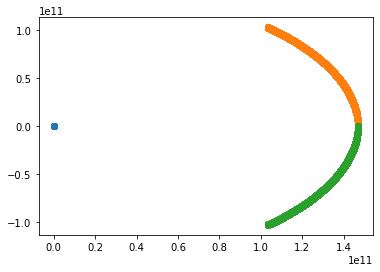

In [7]:
test_two_fishes()

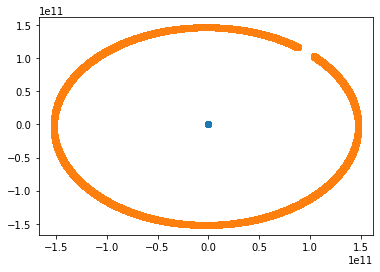

In [8]:
test_one_fish()